## Imports

In [2]:
import os
import torch
from PIL import Image
import numpy as np
import argparse
from torch.utils.data import Dataset
from torchvision.transforms import transforms
from torch.optim.lr_scheduler import OneCycleLR
from data_aug.contrastive_learning_dataset import ContrastiveLearningDataset
from data_aug.view_generator import ContrastiveLearningViewGenerator
from simclr import SimCLR
from models.resnet_simclr import ResNetSimCLR
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import umap

C:\Users\sinha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameters

In [ ]:
batch_size = 512  
epochs = 30      
learning_rate = 0.001  
temperature = 0.1  # Keep this the same
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_views = 2      # Standard SimCLR setting
out_dim = 16     # Reduce from 64 since we have less information per image
disable_cuda = False
fp16_precision = True  # Definitely keep this for your GPU
log_every_n_steps = 25  # More frequent logging since epochs will go faster
arch = 'resnet18'
num_workers = 4   # Reduce from 16 since we have smaller batches to process
weight_decay = 2e-4  # Slightly increased regularization for smaller images

In [4]:
torch.cuda.is_available()

True

## Helpers

In [5]:
def extract_embeddings(model, dataloader, device):
    """
    Extract embeddings from the model for all images in the dataloader.
    Returns embeddings and their corresponding labels.
    """
    model.eval()
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for images, label in dataloader:
            # For SimCLR, we only need one view for evaluation
            if isinstance(images, list):
                images = images[0]
            
            images = images.to(device)
            embedding = model(images)
            
            embeddings.append(embedding.cpu().numpy())
            labels.append(label.numpy())
    
    embeddings = np.vstack(embeddings)
    labels = np.concatenate(labels)
    
    return embeddings, labels

def plot_embeddings(embeddings, labels, method='tsne', title='Embedding Visualization'):
    """
    Visualize embeddings using t-SNE.
    """
    plt.figure(figsize=(10, 8))
    reducer = TSNE(n_components=2, random_state=42)
    
    # Reduce dimensionality
    reduced_embeddings = reducer.fit_transform(embeddings)
    
    # Create scatter plot
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
                         c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)
    
    plt.title(f'{title} (TSNE)')
    plt.xlabel('TSNE 1')
    plt.ylabel('TSNE 2')
    plt.show()

def evaluate_knn(train_embeddings, train_labels, test_embeddings, test_labels, n_neighbors=5):
    """
    Evaluate embeddings using k-NN classification.
    Returns accuracy and confusion matrix.
    """
    # Train k-NN classifier
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(train_embeddings, train_labels)
    
    # Make predictions
    predictions = knn.predict(test_embeddings)
    
    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predictions)
    
    # Create confusion matrix
    conf_matrix = confusion_matrix(test_labels, predictions)
    
    return accuracy, conf_matrix

def plot_confusion_matrix(conf_matrix, class_names=None):
    """
    Plot confusion matrix as a heatmap.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else 'auto',
                yticklabels=class_names if class_names else 'auto')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Function to run full evaluation
def evaluate_model(model, train_loader, test_loader, device):
    """
    Run complete model evaluation including embedding visualization and k-NN classification.
    """
    print("Extracting embeddings...")
    train_embeddings, train_labels = extract_embeddings(model, train_loader, device)
    test_embeddings, test_labels = extract_embeddings(model, test_loader, device)
    
    print("\nVisualizing embeddings...")
    # Visualize training embeddings
    plot_embeddings(train_embeddings, train_labels, method='tsne', 
                   title='Training Set Embeddings')
    
    # Visualize test embeddings
    plot_embeddings(test_embeddings, test_labels, method='tsne', 
                   title='Test Set Embeddings')
    
    print("\nEvaluating k-NN classification...")
    accuracy, conf_matrix = evaluate_knn(train_embeddings, train_labels,
                                       test_embeddings, test_labels)
    
    print(f"\nk-NN Classification Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    plot_confusion_matrix(conf_matrix)
    
    return {
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'train_embeddings': train_embeddings,
        'test_embeddings': test_embeddings,
        'train_labels': train_labels,
        'test_labels': test_labels
    }


## Training

In [6]:
args = argparse.Namespace(
    batch_size=batch_size,
    epochs=epochs,
    lr=learning_rate,
    temperature=temperature,
    device=device,
    n_views=n_views,
    num_workers=num_workers,
    out_dim=out_dim,
    disable_cuda=disable_cuda,
    fp16_precision=fp16_precision,
    log_every_n_steps=log_every_n_steps,
    arch=arch,
    weight_decay=weight_decay
)

In [7]:
train_dataset = ContrastiveLearningDataset(root_folder="datasets_extracted_symbols")
symbol_dataset = train_dataset.get_dataset(name="symbols", n_views=2, split="train")

train_loader = torch.utils.data.DataLoader(
    symbol_dataset,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=True
)

In [8]:
model = ResNetSimCLR(base_model=args.arch, out_dim=args.out_dim)

C:\Users\sinha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sinha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
optimizer = torch.optim.Adam(model.parameters(), 
                             args.lr, 
                             weight_decay=args.weight_decay)

scheduler = OneCycleLR(optimizer,
                      max_lr=args.lr,
                      epochs=args.epochs,
                      steps_per_epoch=len(train_loader),
                      pct_start=0.1)  # 10% warmup

with torch.cuda.device(0):
    simclr = SimCLR(model=model, 
                    optimizer=optimizer, 
                    scheduler=scheduler, 
                    args=args)
    simclr.train(train_loader)

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\sinha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\optim\lr_scheduler.py:1699: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


## Testing

In [10]:
test_dataset = ContrastiveLearningDataset(root_folder="datasets_extracted_symbols")
test_symbol_dataset = test_dataset.get_dataset(name="symbols", n_views=1, split="test")  # Only need 1 view for testing

test_loader = torch.utils.data.DataLoader(
    test_symbol_dataset, 
    batch_size=args.batch_size,
    shuffle=False,  
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=False
)

Extracting embeddings...

Visualizing embeddings...


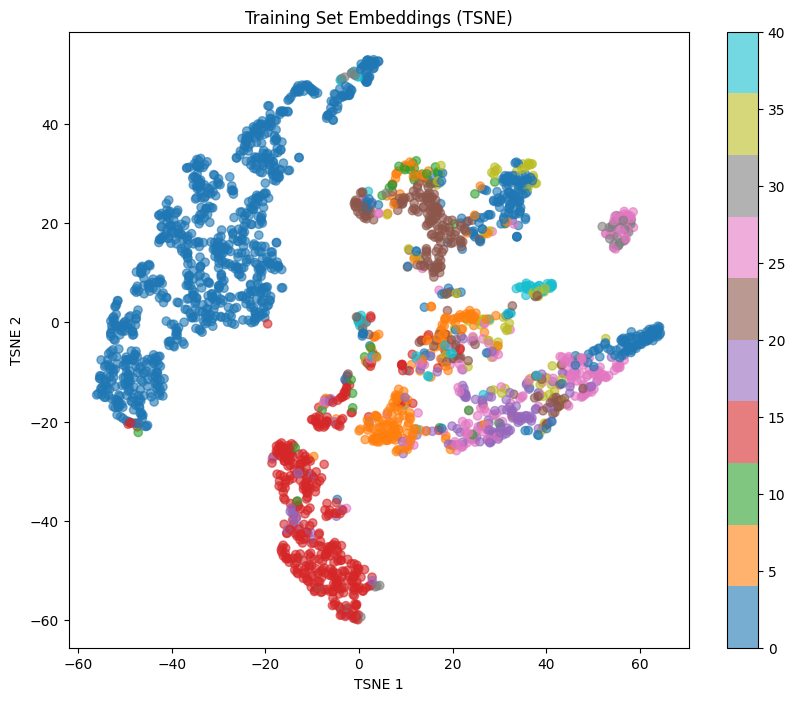

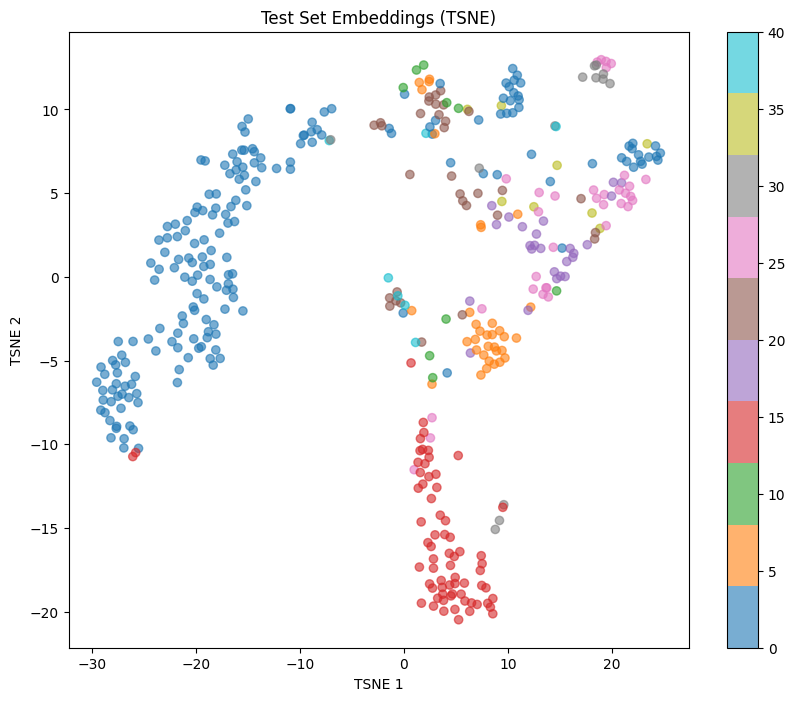


Evaluating k-NN classification...

k-NN Classification Accuracy: 0.7972

Confusion Matrix:


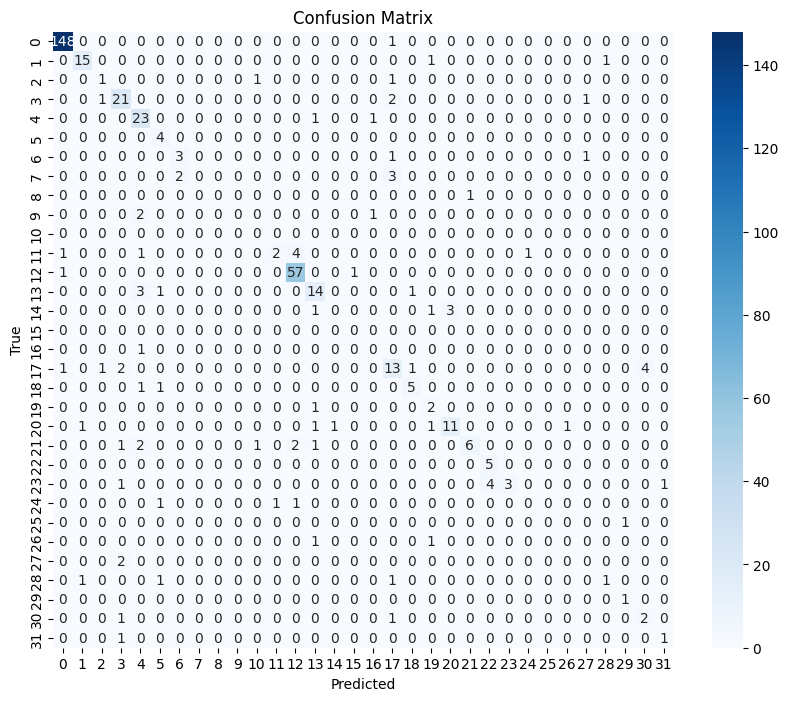

Final accuracy: 0.7971698113207547


In [11]:
# Make sure your model is on the correct device
model = model.to(args.device)

# Run evaluation
results = evaluate_model(model, train_loader, test_loader, args.device)

# You can access individual results like this:
print(f"Final accuracy: {results['accuracy']}")